# Classification Models
## KNN

Now that we’ve reduced the dataset’s dimensionality, it’s especially advantageous to apply K‑Nearest Neighbors. With a more compact feature space free of redundant or noisy variables, distance calculations become more reliable and discriminative, enhancing KNN’s ability to identify truly similar neighbors. Moreover, by working in fewer dimensions, the algorithm’s computational burden is significantly lower, speeding up both training and inference without sacrificing model quality. In this way, KNN emerges as an effective choice to explore the structure of the transformed feature space and establish a robust classification baseline.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.inspection import DecisionBoundaryDisplay
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold, cross_val_score
import seaborn as sns
import os
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

### Comparative KNN Evaluation on PCA, Feature‑Selected & t‑SNE Embeddings

This block of code systematically evaluates a fixed KNN configuration across multiple feature representations by sweeping hyperparameters and using 5‑fold cross‑validation.

In [2]:
# General configuration
k_values = range(1, 16)
weights_options = ['uniform', 'distance']
metrics = ["minkowski", "cosine"]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the comparisons
representations = {
    "PCA_16": "../datasets/X_pca_16.npy",
    "Feature_selection": "../datasets/X_feature_select.npy",
    "X_t-SNE": "../datasets/X_t-SNE.npy"
}

# Load labels
y = np.load("../datasets/y_enc.npy")

# Storage results
all_results = []

for name, path in representations.items():
    X = np.load(path)
    
    for weights in weights_options:
        for k in k_values:
            for metric in metrics:
                model = KNeighborsClassifier(n_neighbors=k, weights=weights, metric= metric )
                # Create a pipeline with scaler and and model 
                pipe = make_pipeline(
                    StandardScaler(),
                    model
                    )

                # Evaluate using cross_val_score on X and y
                scores = cross_val_score(
                    pipe,
                    X,  
                    y,
                    cv=cv,
                    scoring='accuracy'
                    #n_jobs=-1
                )

                all_results.append({
                    "representation": name,
                    "k": k,
                    "weights": weights,
                    "mean_accuracy": np.mean(scores),
                    "std_accuracy": np.std(scores),
                    "metric": metric
                })

# Create a DataFrame
results_df = pd.DataFrame(all_results)

In [3]:
results_df.sort_values(by="mean_accuracy", ascending=False)

,representation,k,weights,mean_accuracy,std_accuracy,metric
110,Feature_selection,11,distance,0.78,0.120830,minkowski
74,Feature_selection,8,uniform,0.78,0.102956,minkowski
104,Feature_selection,8,distance,0.78,0.112250,minkowski
76,Feature_selection,9,uniform,0.77,0.102956,minkowski
98,Feature_selection,5,distance,0.77,0.112250,minkowski
...,...,...,...,...,...,...
175,X_t-SNE,13,distance,0.41,0.048990,cosine
165,X_t-SNE,8,distance,0.40,0.054772,cosine
173,X_t-SNE,12,distance,0.40,0.054772,cosine
169,X_t-SNE,10,distance,0.40,0.054772,cosine


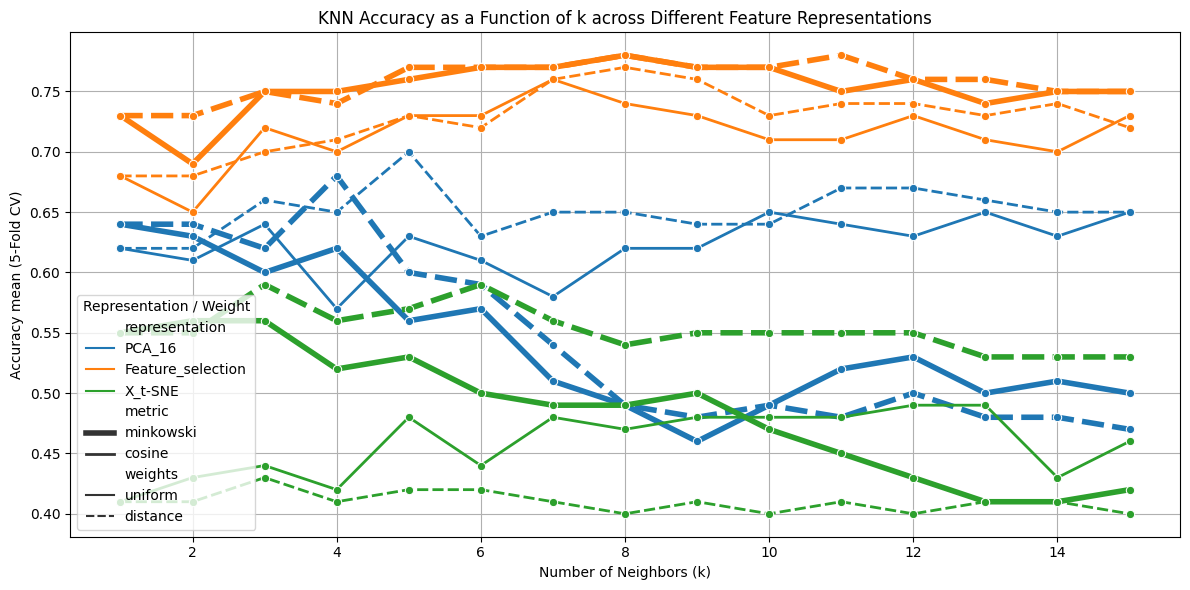

In [4]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x="k", y="mean_accuracy", hue="representation", style="weights", marker="o",size= "metric", sizes=(2,4))
plt.title("KNN Accuracy as a Function of k across Different Feature Representations")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy mean (5-Fold CV)")
plt.grid(True)
plt.legend(title="Representation / Weight")
plt.tight_layout()
plt.show()

### Exhaustive KNN Hyperparameter Search on Selected Features

A GridSearchCV with 5‑fold cross‑validation is used to optimize the hyperparameters of a KNN pipeline (n_neighbors, weights, metric, and p) using only the X_feature_select dataset. The evaluation metric is mean accuracy, and at the end it reports the parameter combination that achieves the best performance.

In [5]:
from sklearn.model_selection import GridSearchCV

# Load X_feature_select and y
X = np.load("../datasets/X_feature_select.npy")
y = np.load("../datasets/y_enc.npy")

# Pipeline
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# Define grid parameters
param_grid = {
    "knn__n_neighbors": list(range(1, 31)),
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski", "cosine"],
    "knn__p": [1, 2]  # Manhattan (1) y Euclidiana (2)
}

# Define search
grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",  
    n_jobs=-1
)

# Fit
grid.fit(X, y)

# Results
print("🔍 Best configuration:")
print(grid.best_params_)
print(f"Best perfomance (accuracy): {grid.best_score_:.4f}")

🔍 Best configuration:
{'knn__metric': 'minkowski', 'knn__n_neighbors': 8, 'knn__p': 2, 'knn__weights': 'uniform'}
Best perfomance (accuracy): 0.8000


Previosly using other parameters this was the best configuration.
🔍 Best configuration using X_pca:
{'knn__metric': 'cosine', 'knn__n_neighbors': 27, 'knn__p': 1, 'knn__weights': 'distance'}
Best perfomance (accuracy): 0.7300

### Training and Evaluation of KNN with Optimal Hyperparameters

In [8]:
clf_KNN = Pipeline(
    steps=[("scaler", StandardScaler()), ("knn", KNeighborsClassifier(n_neighbors=8, metric='minkowski', p=2, weights="uniform"))])

Test accuracy:  0.7666666666666667

Classification report:
               precision    recall  f1-score   support

           0       0.86      1.00      0.92         6
           1       0.50      0.50      0.50         6
           2       1.00      0.67      0.80         6
           3       0.67      0.67      0.67         6
           4       0.86      1.00      0.92         6

    accuracy                           0.77        30
   macro avg       0.78      0.77      0.76        30
weighted avg       0.78      0.77      0.76        30


Confusion matrix:
 [[6 0 0 0 0]
 [1 3 0 2 0]
 [0 2 4 0 0]
 [0 1 0 4 1]
 [0 0 0 0 6]]

Cross‑validation accuracy: 0.7800 ± 0.1030


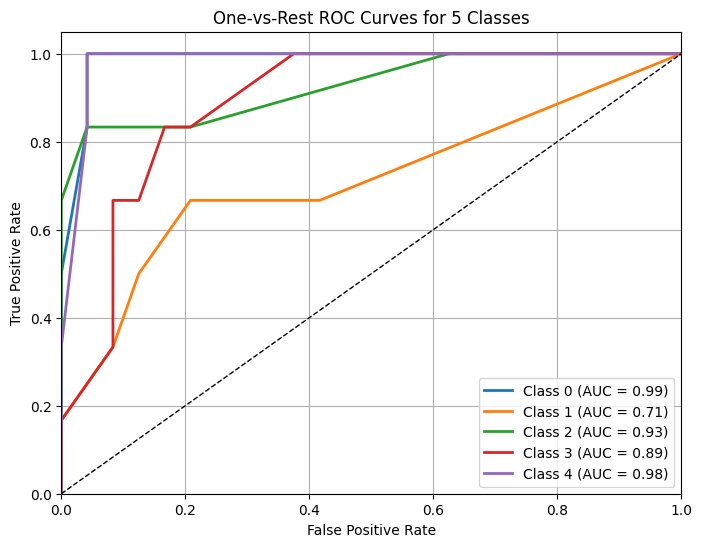

In [9]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

# Fit the KNN pipeline on the training data
clf_KNN.fit(X_train, y_train)

# Generate predictions on the test set
y_pred = clf_KNN.predict(X_test)

# Compute and display basic classification metrics
print("Test accuracy: ", accuracy_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# Display the confusion matrix
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# Estimate cross-validated accuracy (5‑fold StratifiedKFold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(clf_KNN, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"\nCross‑validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

# Plot One‑vs‑Rest ROC curves and compute AUC for each class
#    a) Binarize the test labels in a one‑vs‑rest fashion
y_test_bin = label_binarize(y_test, classes=clf_KNN.classes_)
n_classes = y_test_bin.shape[1]

#    b) Obtain class‑wise predicted probabilities
y_score = clf_KNN.predict_proba(X_test)

#    c) Compute FPR, TPR, and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

#    d) Plot all ROC curves on the same figure
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'Class {clf_KNN.classes_[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.05)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('One‑vs‑Rest ROC Curves for 5 Classes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

The KNN model achieves an overall accuracy of 0.767 on the test set, indicating solid performance. However, when broken down by class:
	•	Classes 0 and 4: Precision and recall of 1.00 (F1 = 0.92), perfectly classified.
	•	Class 2: F1 = 0.80, with a good balance between precision and recall.
	•	Class 3: F1 = 0.67, moderate performance.
	•	Class 1: F1 = 0.50, lags behind—only half of its instances are correctly identified.

The macro‑avg (0.76) and weighted‑avg (0.76) confirm this variability across classes. Additionally, cross‑validation yields a mean accuracy of 0.78 ± 0.10, suggesting the model is reasonably stable, albeit with some variability.